In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [3]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [4]:
Image_RGB.shape

(14142, 64, 64, 5)

In [5]:
#Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max((Image_RGB))

In [251]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 5)
train_label.shape: (14142, 3)


In [18]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 



In [21]:
vae.fit(train_data[:8000], train_data[:8000],
        shuffle=True,
        epochs=5,
        batch_size=batch_size,
        validation_data=(train_data[8000:9500],train_data[8000:9500]),callbacks=[EarlyStopping])

Train on 8000 samples, validate on 1500 samples
Epoch 1/5
8000/8000 [==============================] - 13s - loss: -9649.6650 - val_loss: -9726.2169
Epoch 2/5
8000/8000 [==============================] - 13s - loss: -9654.8510 - val_loss: -9734.2905
Epoch 3/5
8000/8000 [==============================] - 13s - loss: -9673.4231 - val_loss: -9748.1493
Epoch 4/5
8000/8000 [==============================] - 13s - loss: -9666.6225 - val_loss: -9747.9605
Epoch 5/5
8000/8000 [==============================] - 13s - loss: -9675.9198 - val_loss: -9660.1504


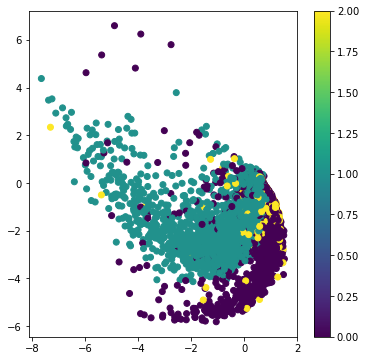

In [22]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])
test_data = train_data[8500:14000]
vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(test_data, batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] , x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.show()

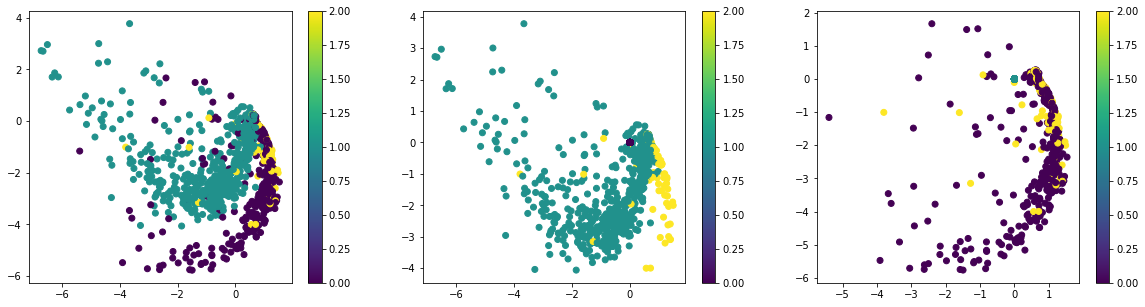

In [269]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:9500], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[8000:9500], batch_size=batch_size)  
x_vis_1[label_value[8000:9500]<1]=0

x_vis_2 = vis.predict(train_data[8000:9500], batch_size=batch_size)  
x_vis_2[label_value[8000:9500]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9500])
plt.colorbar()
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[8000:9500])
plt.colorbar()
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[8000:9500])
plt.colorbar()
plt.show()

In [23]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
model_pool_4 = Model(input_img,maxpool_4)
model_conv_5 = Model(input_img,conv_5)
model_pool_5 = Model(input_img,maxpool_5)
vis = Model(input_img, z_mean)
model_conv_6 = Model(input_img,conv_6)
model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)

In [24]:
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
lyr.append(model_pool_4)
lyr.append(model_conv_5)
lyr.append(model_pool_5)
lyr.append(vis)
lyr.append(model_conv_6)
lyr.append(model_up_6)
lyr.append(model_conv_7)
lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)

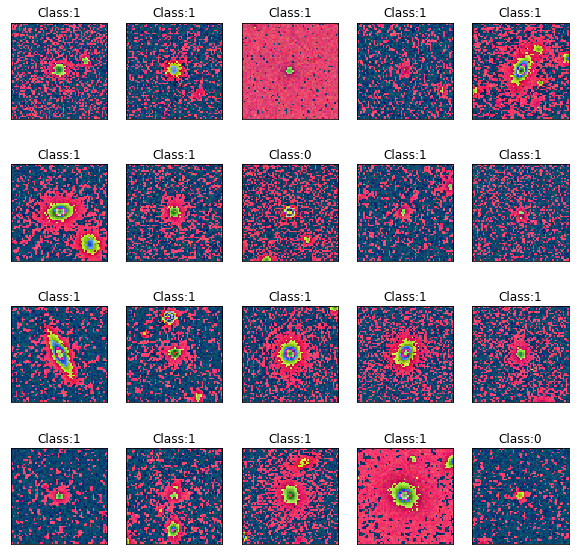

In [256]:
plt.figure(figsize=(10, 10))
for number in range(20):
    ax = plt.subplot(4,5,number+1)
    plt.imshow(train_data[10000+number][:,:,1:4])
    plt.title("Class:%g" %(Class[10000+number]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

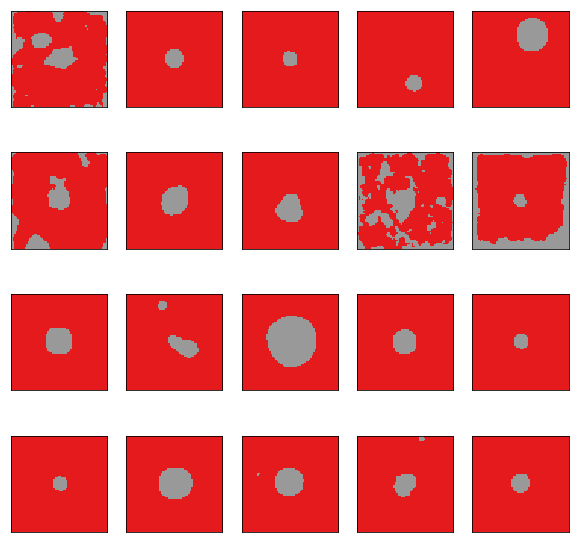

In [29]:
fig = plt.figure(figsize=(10, 10))
for number in range(20):
    No_ = number
    hypercolumns = []
    for i in [0,1,2,3,4,5,6,7,8,9]:
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    if np.mean(cluster_labels)>0.5:
        cluster_labels = -cluster_labels
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    ax = plt.subplot(4,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [258]:
import scipy
#use the No_ th figure

RANGE=20
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in range(np.shape(lyr)[0]-18):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10000:10100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
#    for i in range(1):
#        hypercolumns_class.append(np.ones((64,64))*lyr[10].predict(train_data[0:100],batch_size=100)[No_,0])
#    hypercolumns = np.vstack((hypercolumns,hypercolumns_class))
    total_hyp.append(hypercolumns)

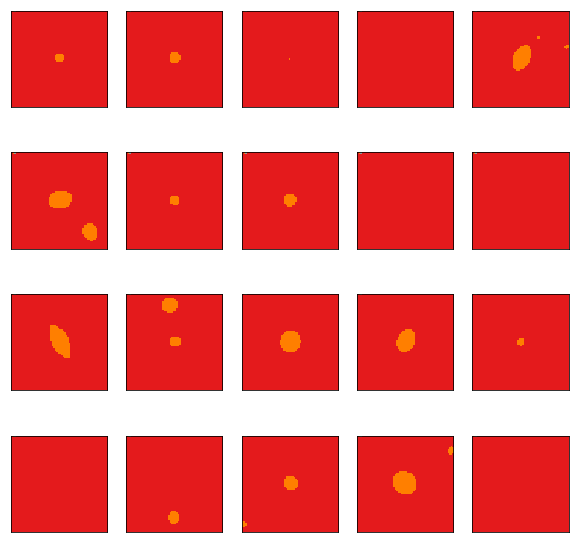

In [270]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2
#imcluster = np.zeros((64,64,RANGE))
#imcluster = imcluster.reshape((64*64*RANGE,))

fig = plt.figure(figsize=(10, 10))
for i in range(RANGE):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [273]:
unsup_class = lyr[10].predict(train_data[10000:10100],batch_size=100)

In [275]:
for i in range(RANGE):
    if (unsup_class[i,0]<0.5 and unsup_class[i,1]>-4):
        imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==1] =2
        imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==0] =0
        imcluster[i*64*64:(i+1)*64*64][0]=0
        imcluster[i*64*64:(i+1)*64*64][1]=1
        imcluster[i*64*64:(i+1)*64*64][2]=2
    else:
        imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==1] =1
        imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==0] =0
        imcluster[i*64*64:(i+1)*64*64][0]=0
        imcluster[i*64*64:(i+1)*64*64][1]=1
        imcluster[i*64*64:(i+1)*64*64][2]=2

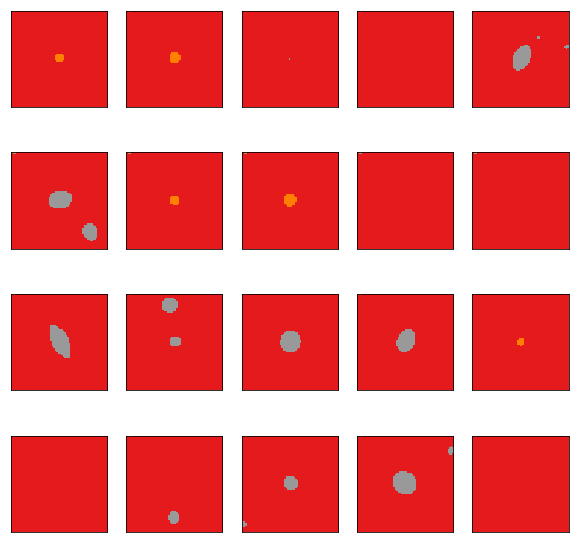

In [278]:
fig = plt.figure(figsize=(10, 10))
for i in range(RANGE):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [279]:
Class[10000:10100][:20]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

# Only one Hid-Variable

In [300]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.5  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 



In [301]:
vae.fit(train_data[:8000], train_data[:8000],
        shuffle=True,
        epochs=5,
        batch_size=batch_size,
        validation_data=(train_data[8000:9500],train_data[8000:9500]),callbacks=[EarlyStopping])

Train on 8000 samples, validate on 1500 samples
Epoch 1/5
8000/8000 [==============================] - 14s - loss: -9217.4709 - val_loss: -9432.7016
Epoch 2/5
8000/8000 [==============================] - 13s - loss: -9452.4252 - val_loss: -9453.6591
Epoch 3/5
8000/8000 [==============================] - 13s - loss: -9599.8615 - val_loss: -9671.7958
Epoch 4/5
8000/8000 [==============================] - 13s - loss: -9659.4868 - val_loss: -9450.5277
Epoch 5/5
8000/8000 [==============================] - 13s - loss: -9614.0976 - val_loss: -9515.5425


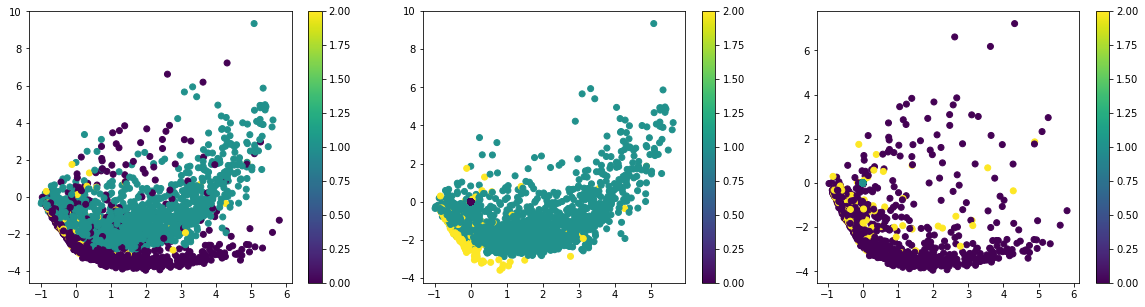

In [302]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:14000], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[8000:14000], batch_size=batch_size)  
x_vis_1[label_value[8000:14000]<1]=0

x_vis_2 = vis.predict(train_data[8000:14000], batch_size=batch_size)  
x_vis_2[label_value[8000:14000]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:14000])
plt.colorbar()
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[8000:14000])
plt.colorbar()
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[8000:14000])
plt.colorbar()
plt.show()

Automatically created module for IPython interactive environment
standard: 1.1 sec
modified: 2 sec
Isomap: 22 sec
MDS: 1.3e+02 sec
SpectralEmbedding: 1.6 sec
t-SNE: 1.4e+02 sec


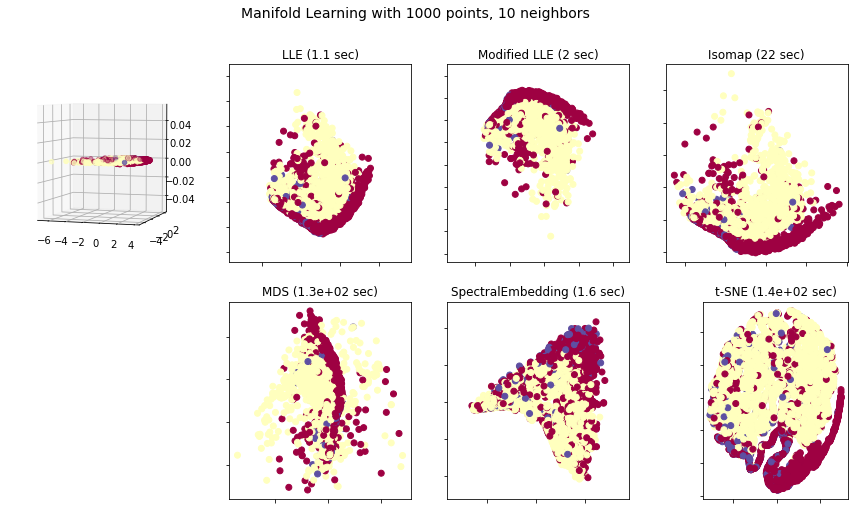

In [294]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 6000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8000:14000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

# Regression for Redshift

In [101]:
batch_size =100
latent_dim = 1
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 300
#intermediate_dim_2 = 300
original_dim = 64*64

LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

input_img = Input(shape=(64,64,5))
x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(input_img)
x = Dropout(0.25)(x)


conv_1 = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)
maxpool_1 = Dropout(0.25)(maxpool_1)

x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_1)
x = Dropout(0.25)(x)

conv_2 = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)
maxpool_2 = Dropout(0.25)(maxpool_2)

x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_2)
x = Dropout(0.25)(x)

conv_3 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)
maxpool_3 = Dropout(0.25)(maxpool_3)

conv_4 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)
maxpool_4 = Dropout(0.25)(maxpool_4)

conv_5 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)
maxpool_5 = Dropout(0.25)(maxpool_5)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation=LRelu)(visual)
h_1 = Dropout(0.25)(h_1)
redshift = Dense(latent_dim, activation='sigmoid')(h_1)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


model = Model(inputs=input_img, outputs=redshift) 
model.compile(optimizer='rmsprop', loss='mean_squared_error') 

In [102]:
model.fit(train_data[:8000], Redshift[:8000]/2,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[8000:9500],Redshift[8000:9500]/2),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 1500 samples
Epoch 1/50
8000/8000 [==============================] - 16s - loss: 0.0513 - val_loss: 0.0567
Epoch 2/50
8000/8000 [==============================] - 15s - loss: 0.0501 - val_loss: 0.0569
Epoch 3/50
8000/8000 [==============================] - 15s - loss: 0.0504 - val_loss: 0.0569
Epoch 4/50
8000/8000 [==============================] - 15s - loss: 0.0510 - val_loss: 0.0483
Epoch 5/50
8000/8000 [==============================] - 15s - loss: 0.0332 - val_loss: 0.0477
Epoch 6/50
8000/8000 [==============================] - 15s - loss: 0.0277 - val_loss: 0.0302
Epoch 7/50
8000/8000 [==============================] - 15s - loss: 0.0262 - val_loss: 0.0230
Epoch 8/50
8000/8000 [==============================] - 15s - loss: 0.0175 - val_loss: 0.0204
Epoch 9/50
8000/8000 [==============================] - 15s - loss: 0.0162 - val_loss: 0.0179
Epoch 10/50
8000/8000 [==============================] - 15s - loss: 0.0154 - val_loss: 0.0179
Epoch 11/50

In [111]:
rdsft_predict = model.predict(train_data[100:150])

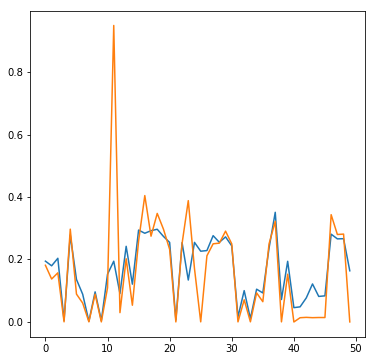

In [112]:
plt.figure(figsize=(6, 6))
plt.plot( rdsft_predict)
plt.plot(Redshift[100:150]/2)
#plt.colorbar()
plt.show()

In [109]:
rdsft_predict = model.predict(train_data[10000:10050])

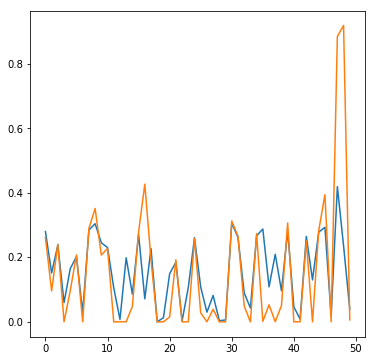

In [110]:
plt.figure(figsize=(6, 6))
plt.plot( rdsft_predict)
plt.plot(Redshift[10000:10050]/2)
#plt.colorbar()
plt.show()

In [116]:
red_pred_1 = model.predict(train_data[8000:8500])

In [117]:
train_data[0].shape

(64, 64, 5)

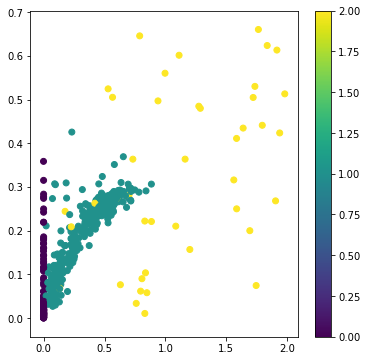

In [118]:
plt.figure(figsize=(6, 6))
plt.scatter( Redshift[8000:8500],red_pred_1,c=label_value[8000:8500])
plt.colorbar()
plt.show()

# density based clustering methods (other than kmeans)

## try to use the first layer and the last layer(after manifold learning) (hypercolumns)